In [1]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback

os.environ["WANDB_SILENT"] = "true"

#### Logistic Regression: Formula Label Prediction (Variant 1: Stream of math tokens)

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

#from tf.keras.callbacks import tensorboard_callback

import datetime

tfds.disable_progress_bar()
wandb_project_name = "binary_formula_classification"

In [4]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tmp/tfdbg2_logdir")
"""
tf.debugging.experimental.enable_dump_debug_info(
    "./tmp/tfdbg2_logdir",
    tensor_debug_mode="FULL_HEALTH",
    circular_buffer_size=-1)
"""

'\ntf.debugging.experimental.enable_dump_debug_info(\n    "./tmp/tfdbg2_logdir",\n    tensor_debug_mode="FULL_HEALTH",\n    circular_buffer_size=-1)\n'

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [6]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["type_tokens"] = corpus["type_tokens"].map(process_cell)

In [7]:
#print(os.getcwd())
data_p = Path("../data/") / "bin_class_data_TOKENIZED_SET_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()


,tokens,type_tokens,label
0,"['f', ':', 'A', '\\to', 'B']",func_def func_name __ANON_1 COLON mapping __AN...,1
1,['f'],func_name __ANON_1,1
2,"['g', '\\colon', 'B', '\\to', 'I']",func_def func_name __ANON_1 COLON mapping __AN...,1
3,"['\\frac', '{', '8', '!', '}', '{', '(', '8', ...",expr_atom CMD_FRAC L_BRACE postfix expr_atom _...,1
4,['f'],func_name __ANON_1,1


In [8]:
SIZE_TRAIN_DS = 10000
SIZE_TEST_DS = 1000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["type_tokens"], data["label"])) 
test_dataset = data_as_ds.take(SIZE_TEST_DS)
train_dataset = data_as_ds.skip(SIZE_TEST_DS)

##### Setup and Data Preparation

In [9]:
for example, label in train_dataset.take(3):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  b'func_name __ANON_1'
label:  1
text:  b'func_name __ANON_1'
label:  1
text:  b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0'
label:  1


In [10]:
BUFFER_SIZE = SIZE_TRAIN_DS
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SIZE_TRAIN_DS/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SIZE_TEST_DS/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [11]:
def create_encoder(output_mode_str, n_grams):
    VOCAB_SIZE = 1000
    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        split="whitespace",
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda tokens, label: tokens)) # removes the label column through transformation: text, label -> text
    return encoder

##### Representation 1: Use integer indices encoding

In [12]:
encoder_int = create_encoder("int", None)
vocab = np.array(encoder_int.get_vocabulary())
vocab[:200]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


array(['', '[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       '__ANON_0', 'COLON', 'mapping', 'func_def', 'TO', 'additive',
       'CARET', 'unary', 'L_PAREN', 'R_PAREN', 'integer', 'R_BRACE',
       'L_BRACE', 'exp', 'ADD', 'set_constant', 'SET_BASIC', 'SUB',
       'item', 'group', 'COMMA', 'func_name_arg', 'func_expr', 'EQUAL',
       'set_expr', 'CMD_FRAC', 'R_BRACE_LITERAL', 'L_BRACE_LITERAL',
       'explset', 'SET_FAT', 'mp', 'set_enumeration', 'sets__OP_CART',
       'interval', 'DIV', 'UNC_NORMA', 'number', 'R_BRACKET', 'L_BRACKET',
       'sets__OP_UNION', 'sets__OP_INTERSEC', 'CMD_CDOT', 'func_arg',
       'postfix', 'BANG', 'OP_FUNC_COMP', 'func_composed', 'et_constan',
       'MUL', 'func_enumeration', 'CMD_TIMES', 'FUNC_NORMAL', 'CMD_BINOM'],
      dtype='<U17')

In [13]:
encoded_example = encoder_int(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)
print(label.shape)

tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[ 9  5  2  7  8  6 10  6]
(8,)
()


In [14]:
print("Original: ", example.numpy())
print("After reverse lookup: ", " ".join(vocab[encoded_example]))

Original:  b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0'
After reverse lookup:  func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0


##### Representation 2: Binary Count Vectorizer

In [15]:
encoder_multi_hot = create_encoder("multi_hot", None)
vocab = np.array(encoder_multi_hot.get_vocabulary())
vocab[:200]

array(['[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       '__ANON_0', 'COLON', 'mapping', 'func_def', 'TO', 'additive',
       'CARET', 'unary', 'L_PAREN', 'R_PAREN', 'integer', 'exp',
       'R_BRACE', 'L_BRACE', 'ADD', 'set_constant', 'SET_BASIC', 'SUB',
       'item', 'group', 'COMMA', 'func_name_arg', 'func_expr', 'EQUAL',
       'set_expr', 'CMD_FRAC', 'R_BRACE_LITERAL', 'L_BRACE_LITERAL',
       'explset', 'SET_FAT', 'mp', 'set_enumeration', 'sets__OP_CART',
       'interval', 'DIV', 'UNC_NORMA', 'number', 'R_BRACKET', 'L_BRACKET',
       'sets__OP_UNION', 'sets__OP_INTERSEC', 'CMD_CDOT', 'func_arg',
       'postfix', 'BANG', 'OP_FUNC_COMP', 'func_composed', 'et_constan',
       'MUL', 'func_enumeration', 'CMD_TIMES', 'FUNC_NORMAL', 'CMD_BINOM'],
      dtype='<U17')

In [16]:
encoded_example = encoder_multi_hot(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(58,)


##### Representation 3: Frequency Count Vectorizer

In [17]:
encoder_count = create_encoder("count", None)
vocab = np.array(encoder_count.get_vocabulary())
vocab[:200]

array(['[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       '__ANON_0', 'COLON', 'mapping', 'func_def', 'TO', 'additive',
       'CARET', 'unary', 'L_PAREN', 'R_PAREN', 'integer', 'exp',
       'R_BRACE', 'L_BRACE', 'ADD', 'set_constant', 'SET_BASIC', 'SUB',
       'item', 'group', 'COMMA', 'func_name_arg', 'func_expr', 'EQUAL',
       'set_expr', 'CMD_FRAC', 'R_BRACE_LITERAL', 'L_BRACE_LITERAL',
       'explset', 'SET_FAT', 'mp', 'set_enumeration', 'interval',
       'sets__OP_CART', 'DIV', 'UNC_NORMA', 'number', 'R_BRACKET',
       'L_BRACKET', 'sets__OP_UNION', 'sets__OP_INTERSEC', 'CMD_CDOT',
       'func_arg', 'postfix', 'BANG', 'OP_FUNC_COMP', 'func_composed',
       'et_constan', 'MUL', 'func_enumeration', 'CMD_TIMES',
       'FUNC_NORMAL', 'CMD_BINOM'], dtype='<U17')

In [18]:
encoded_example = encoder_count(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[0. 1. 0. 0. 1. 2. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(58,)


##### Representation 4: Bigrams Frequency Count Vectorizer

In [19]:
encoder_bigrams = create_encoder("count", (2))
vocab = np.array(encoder_bigrams.get_vocabulary())
vocab[:200]

array(['[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       'func_name __ANON_1', 'expr_atom __ANON_3', '__ANON_0',
       '__ANON_3 __ANON_3', 'COLON', 'mapping', 'func_def', 'TO',
       'COLON mapping', 'func_def func_name', '__ANON_1 COLON',
       'additive', 'CARET', 'unary', 'L_PAREN', 'R_PAREN', '__ANON_0 TO',
       'integer __ANON_3', 'integer', 'expr_atom integer', 'R_BRACE',
       'L_BRACE', 'exp', 'TO __ANON_0', 'mapping __ANON_0',
       '__ANON_1 R_PAREN', 'ADD', 'set_constant',
       'set_constant SET_BASIC', 'SET_BASIC', 'SUB', 'L_PAREN __ANON_1',
       'item', 'exp __ANON_1', '__ANON_1 CARET', 'group', 'COMMA',
       'group L_PAREN', '__ANON_3 R_BRACE', 'CARET expr_atom',
       '__ANON_1 ADD', 'func_name __ANON_0', 'unary __ANON_1',
       'func_name_arg', 'func_expr func_name_arg', 'func_expr',
       'R_PAREN EQUAL', 'EQUAL', 'func_name_arg func_name',
       'additive __ANON_1', '__ANON_1 L_PAREN', 'unary expr_atom',
       'set_expr', 'SUB expr_a

In [20]:
encoded_example = encoder_bigrams(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[0. 1. 0. 0. 1. 1. 0. 2. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0

##### Representation 5: Tf-Idf Vectorizer

In [21]:
encoder_tf_idf = create_encoder("tf_idf", None)
vocab = np.array(encoder_tf_idf.get_vocabulary())
vocab[:200]

array(['[UNK]', '__ANON_1', '__ANON_3', 'expr_atom', 'func_name',
       '__ANON_0', 'COLON', 'mapping', 'func_def', 'TO', 'additive',
       'CARET', 'unary', 'L_PAREN', 'R_PAREN', 'integer', 'exp',
       'R_BRACE', 'L_BRACE', 'ADD', 'set_constant', 'SET_BASIC', 'SUB',
       'item', 'group', 'COMMA', 'func_name_arg', 'func_expr', 'EQUAL',
       'set_expr', 'CMD_FRAC', 'R_BRACE_LITERAL', 'L_BRACE_LITERAL',
       'explset', 'SET_FAT', 'mp', 'set_enumeration', 'interval',
       'sets__OP_CART', 'DIV', 'UNC_NORMA', 'number', 'R_BRACKET',
       'L_BRACKET', 'sets__OP_UNION', 'sets__OP_INTERSEC', 'CMD_CDOT',
       'func_arg', 'postfix', 'BANG', 'OP_FUNC_COMP', 'func_composed',
       'et_constan', 'MUL', 'func_enumeration', 'CMD_TIMES',
       'FUNC_NORMAL', 'CMD_BINOM'], dtype='<U17')

In [22]:
encoded_example = encoder_tf_idf(example).numpy()
print(example)
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0', shape=(), dtype=string)
[0.        0.9789967 0.        0.        1.0944893 3.4092503 1.9361864
 1.9366951 1.9366951 1.9366951 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.       ]
(58,)


##### Model (Logistic Regression)

 **Define and compile model**

In [23]:
def create_model(vec_encoder, add_inp_emb_dim=1):
    embedding_input_dim = len(vec_encoder.get_vocabulary()) + add_inp_emb_dim
    model = tf.keras.Sequential([
        vec_encoder,
        tf.keras.layers.Embedding(
            input_dim=embedding_input_dim,
            output_dim=16,
            # user masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    return model

 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [24]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [25]:
model = create_model(encoder_int)
# predict on a sample formula using untrained model
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 70ms/step
[0.05015446]


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          960       
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [27]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])


In [28]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
155/156 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.5591INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


156/156 [==============================] - 3s 19ms/step - loss: 0.6496 - accuracy: 0.5599 - val_loss: 0.6045 - val_accuracy: 0.0000e+00
Epoch 2/200
137/156 [=========================>....] - ETA: 0s - loss: 0.5543 - accuracy: 0.6946INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.5510 - accuracy: 0.6957 - val_loss: 0.5123 - val_accuracy: 0.5042
Epoch 3/200
134/156 [========================>.....] - ETA: 0s - loss: 0.4980 - accuracy: 0.7263INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


156/156 [==============================] - 1s 7ms/step - loss: 0.4961 - accuracy: 0.7284 - val_loss: 0.5039 - val_accuracy: 0.5385
Epoch 4/200
138/156 [=========================>....] - ETA: 0s - loss: 0.4746 - accuracy: 0.7382INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.4775 - accuracy: 0.7364 - val_loss: 0.4774 - val_accuracy: 0.5531
Epoch 5/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4683 - accuracy: 0.7473 - val_loss: 0.4827 - val_accuracy: 0.5573
Epoch 6/200
126/156 [=======================>......] - ETA: 0s - loss: 0.4625 - accuracy: 0.7514INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.4655 - accuracy: 0.7472 - val_loss: 0.4740 - val_accuracy: 0.5604
Epoch 7/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.7484 - val_loss: 0.4838 - val_accuracy: 0.5635
Epoch 8/200
151/156 [============================>.] - ETA: 0s - loss: 0.4571 - accuracy: 0.7519INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


156/156 [==============================] - 1s 7ms/step - loss: 0.4592 - accuracy: 0.7501 - val_loss: 0.4705 - val_accuracy: 0.5729
Epoch 9/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4586 - accuracy: 0.7574 - val_loss: 0.4731 - val_accuracy: 0.5729
Epoch 10/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4603 - accuracy: 0.7525 - val_loss: 0.4805 - val_accuracy: 0.5729
Epoch 11/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4564 - accuracy: 0.7580 - val_loss: 0.4908 - val_accuracy: 0.5635
Epoch 12/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.7529 - val_loss: 0.4833 - val_accuracy: 0.5688
Epoch 13/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4574 - accuracy: 0.7524 - val_loss: 0.4831 - val_accuracy: 0.5719
Epoch 14/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7562 - val_loss: 0.4861 - val_accuracy: 0.5719
Epoch 

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_112841-9u92yyu1/files/model-best/assets


156/156 [==============================] - 2s 13ms/step - loss: 0.4544 - accuracy: 0.7538 - val_loss: 0.4704 - val_accuracy: 0.5760
Epoch 19/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4560 - accuracy: 0.7568 - val_loss: 0.4705 - val_accuracy: 0.5760
Epoch 20/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.7573 - val_loss: 0.4742 - val_accuracy: 0.5760
Epoch 21/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4568 - accuracy: 0.7551 - val_loss: 0.4859 - val_accuracy: 0.5760
Epoch 22/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4550 - accuracy: 0.7548 - val_loss: 0.4874 - val_accuracy: 0.5750
Epoch 23/200
156/156 [==============================] - 0s 3ms/step - loss: 0.4548 - accuracy: 0.7548 - val_loss: 0.4830 - val_accuracy: 0.5750
Epoch 24/200
156/156 [==============================] - 0s 2ms/step - loss: 0.4510 - accuracy: 0.7525 - val_loss: 0.4727 - val_accuracy: 0.5760
Epoc

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 893us/step - loss: 0.4997 - accuracy: 0.8875
Test Loss: 0.49972259998321533
Test Accuracy: 0.887499988079071


(0.0, 0.6598498702049256)

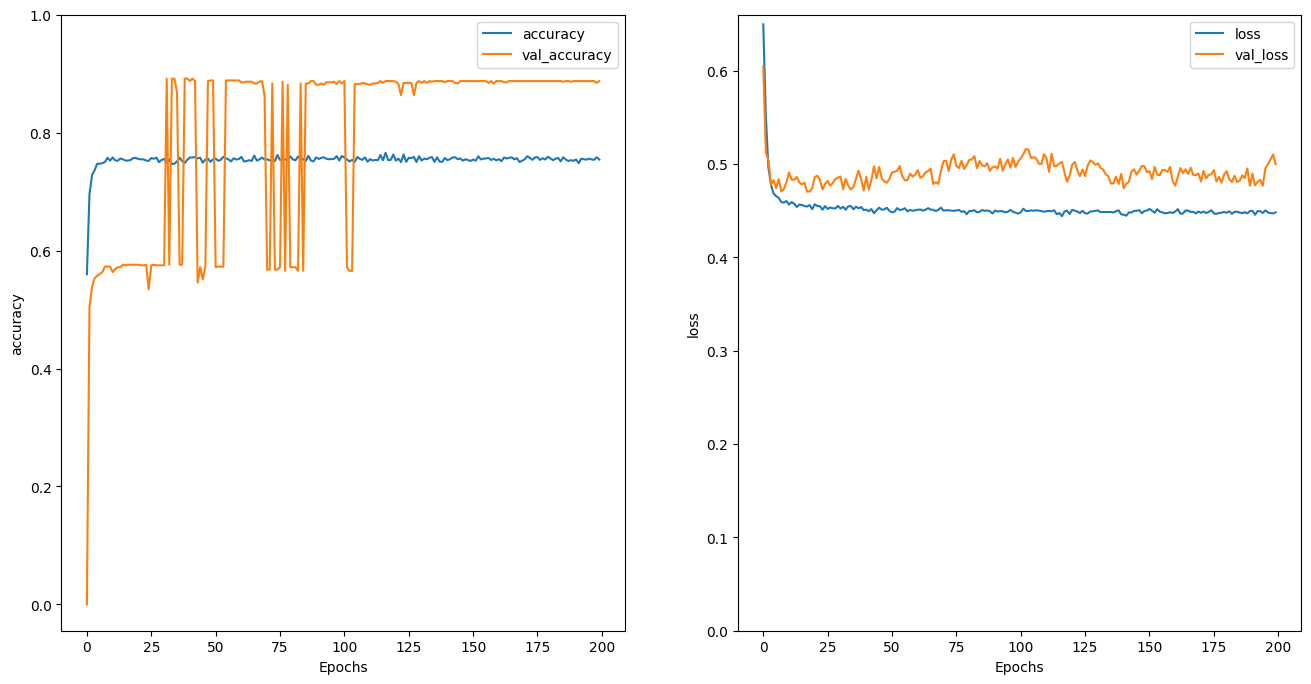

In [30]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [31]:
# predict on a sample text without padding
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 76ms/step
[0.83682406]


##### Experiment 2: Use binary count vectorizer for encoding

In [32]:
model = create_model(encoder_multi_hot)
# predict on a sample formula using untrained model
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 67ms/step
[-0.01876398]


In [33]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [34]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
135/156 [========================>.....] - ETA: 0s - loss: 0.6892 - accuracy: 0.5513INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113014-5jh6bsw6/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113014-5jh6bsw6/files/model-best/assets


156/156 [==============================] - 2s 9ms/step - loss: 0.6895 - accuracy: 0.5496 - val_loss: 0.7617 - val_accuracy: 0.0000e+00
Epoch 2/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5498 - val_loss: 0.7995 - val_accuracy: 0.0000e+00
Epoch 3/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5500 - val_loss: 0.7767 - val_accuracy: 0.0000e+00
Epoch 4/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5501 - val_loss: 0.7971 - val_accuracy: 0.0000e+00
Epoch 5/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5499 - val_loss: 0.8079 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5498 - val_loss: 0.8177 - val_accuracy: 0.0000e+00
Epoch 7/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5501 - val_loss: 0.8047 - val_accu

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113014-5jh6bsw6/files/model-best/assets


156/156 [==============================] - 1s 7ms/step - loss: 0.6882 - accuracy: 0.5500 - val_loss: 0.7246 - val_accuracy: 0.0000e+00
Epoch 67/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5501 - val_loss: 0.7353 - val_accuracy: 0.0000e+00
Epoch 68/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5497 - val_loss: 0.7325 - val_accuracy: 0.0000e+00
Epoch 69/200
138/156 [=========================>....] - ETA: 0s - loss: 0.6885 - accuracy: 0.5486INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113014-5jh6bsw6/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113014-5jh6bsw6/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6882 - accuracy: 0.5502 - val_loss: 0.7234 - val_accuracy: 0.0000e+00
Epoch 70/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5501 - val_loss: 0.7462 - val_accuracy: 0.0000e+00
Epoch 71/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5500 - val_loss: 0.7293 - val_accuracy: 0.0000e+00
Epoch 72/200
130/156 [========================>.....] - ETA: 0s - loss: 0.6881 - accuracy: 0.5516INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113014-5jh6bsw6/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113014-5jh6bsw6/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6883 - accuracy: 0.5499 - val_loss: 0.7149 - val_accuracy: 0.0000e+00
Epoch 73/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.5498 - val_loss: 0.7342 - val_accuracy: 0.0000e+00
Epoch 74/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5500 - val_loss: 0.7242 - val_accuracy: 0.0000e+00
Epoch 75/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5497 - val_loss: 0.7764 - val_accuracy: 0.0000e+00
Epoch 76/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.5500 - val_loss: 0.9127 - val_accuracy: 0.0000e+00
Epoch 77/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.5498 - val_loss: 0.9647 - val_accuracy: 0.0000e+00
Epoch 78/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5503 - val_loss: 1.1217 - v

In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 855us/step - loss: 2.4033 - accuracy: 0.0000e+00
Test Loss: 2.403331995010376
Test Accuracy: 0.0


(0.0, 2.744709399342537)

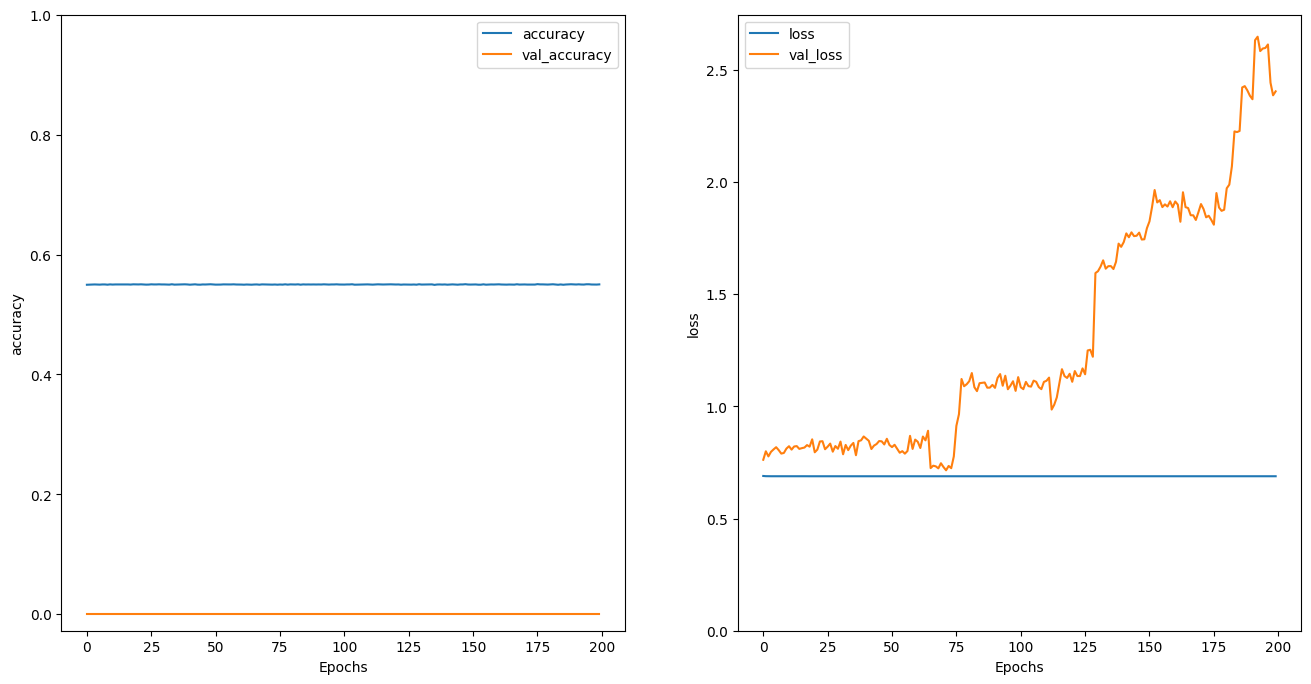

In [36]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [37]:
# predict on a sample text without padding
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 74ms/step
[-2.3085642]


##### Experiment 3:

In [41]:
model = create_model(encoder_count, 30)
# predict on a sample formula using untrained model
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 87ms/step
[0.00397067]


In [42]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [43]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])


run.finish()

Epoch 1/200
141/156 [==========================>...] - ETA: 0s - loss: 0.6755 - accuracy: 0.5479INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 9ms/step - loss: 0.6743 - accuracy: 0.5501 - val_loss: 0.7467 - val_accuracy: 0.0000e+00
Epoch 2/200
146/156 [===========================>..] - ETA: 0s - loss: 0.6665 - accuracy: 0.5493INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6656 - accuracy: 0.5499 - val_loss: 0.7346 - val_accuracy: 0.0000e+00
Epoch 3/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.5501 - val_loss: 0.7463 - val_accuracy: 0.0000e+00
Epoch 4/200
146/156 [===========================>..] - ETA: 0s - loss: 0.6658 - accuracy: 0.5516INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6657 - accuracy: 0.5502 - val_loss: 0.7194 - val_accuracy: 0.0000e+00
Epoch 5/200
147/156 [===========================>..] - ETA: 0s - loss: 0.6640 - accuracy: 0.5492INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6645 - accuracy: 0.5502 - val_loss: 0.7083 - val_accuracy: 0.0000e+00
Epoch 6/200
154/156 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.5506INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6652 - accuracy: 0.5500 - val_loss: 0.6894 - val_accuracy: 0.0000e+00
Epoch 7/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.5501 - val_loss: 0.7299 - val_accuracy: 0.0000e+00
Epoch 8/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6642 - accuracy: 0.5495 - val_loss: 0.6920 - val_accuracy: 0.0000e+00
Epoch 9/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6639 - accuracy: 0.5498 - val_loss: 0.6961 - val_accuracy: 0.0000e+00
Epoch 10/200
131/156 [========================>.....] - ETA: 0s - loss: 0.6644 - accuracy: 0.5505INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6636 - accuracy: 0.5500 - val_loss: 0.6729 - val_accuracy: 0.0000e+00
Epoch 11/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6635 - accuracy: 0.5502 - val_loss: 0.6791 - val_accuracy: 0.0000e+00
Epoch 12/200
150/156 [===========================>..] - ETA: 0s - loss: 0.6629 - accuracy: 0.5502INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6625 - accuracy: 0.5501 - val_loss: 0.6640 - val_accuracy: 0.0000e+00
Epoch 13/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.5500 - val_loss: 0.6752 - val_accuracy: 0.0000e+00
Epoch 14/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.5502 - val_loss: 0.6776 - val_accuracy: 0.0000e+00
Epoch 15/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.5498 - val_loss: 0.6856 - val_accuracy: 0.0000e+00
Epoch 16/200
132/156 [========================>.....] - ETA: 0s - loss: 0.6631 - accuracy: 0.5516INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6640 - accuracy: 0.5502 - val_loss: 0.6556 - val_accuracy: 0.0000e+00
Epoch 17/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6666 - accuracy: 0.5502 - val_loss: 0.6815 - val_accuracy: 0.0000e+00
Epoch 18/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5501 - val_loss: 0.6624 - val_accuracy: 0.0000e+00
Epoch 19/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.5497 - val_loss: 0.6631 - val_accuracy: 0.0000e+00
Epoch 20/200
130/156 [========================>.....] - ETA: 0s - loss: 0.6632 - accuracy: 0.5499INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6641 - accuracy: 0.5498 - val_loss: 0.6533 - val_accuracy: 0.0000e+00
Epoch 21/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6649 - accuracy: 0.5500 - val_loss: 0.6629 - val_accuracy: 0.0000e+00
Epoch 22/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.5503 - val_loss: 0.6648 - val_accuracy: 0.0000e+00
Epoch 23/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6633 - accuracy: 0.5501 - val_loss: 0.6659 - val_accuracy: 0.0000e+00
Epoch 24/200
156/156 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.5503INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6616 - accuracy: 0.5503 - val_loss: 0.6466 - val_accuracy: 0.0000e+00
Epoch 25/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.5498 - val_loss: 0.6642 - val_accuracy: 0.0000e+00
Epoch 26/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.5504 - val_loss: 0.6682 - val_accuracy: 0.0000e+00
Epoch 27/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.5499 - val_loss: 0.6861 - val_accuracy: 0.0000e+00
Epoch 28/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.5503 - val_loss: 0.6482 - val_accuracy: 0.0000e+00
Epoch 29/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.5503 - val_loss: 0.6624 - val_accuracy: 0.0000e+00
Epoch 30/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.5498 - val_loss: 0.6529 - va

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6650 - accuracy: 0.5499 - val_loss: 0.6097 - val_accuracy: 0.0000e+00
Epoch 33/200
148/156 [===========================>..] - ETA: 0s - loss: 0.6636 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6639 - accuracy: 0.5502 - val_loss: 0.5944 - val_accuracy: 0.0000e+00
Epoch 34/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6642 - accuracy: 0.5498 - val_loss: 0.6095 - val_accuracy: 0.0000e+00
Epoch 35/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.5497 - val_loss: 0.6264 - val_accuracy: 0.0000e+00
Epoch 36/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.5497 - val_loss: 0.6123 - val_accuracy: 0.0000e+00
Epoch 37/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.5500 - val_loss: 0.6127 - val_accuracy: 0.0000e+00
Epoch 38/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6658 - accuracy: 0.5497 - val_loss: 0.6206 - val_accuracy: 0.0000e+00
Epoch 39/200
134/156 [========================>.....] - ETA: 0s - loss: 0.6613 - accuracy: 0.5539INFO:tensorflow:Assets writt

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6627 - accuracy: 0.5498 - val_loss: 0.5749 - val_accuracy: 0.0000e+00
Epoch 40/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5498 - val_loss: 0.6019 - val_accuracy: 0.0000e+00
Epoch 41/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.5498 - val_loss: 0.6021 - val_accuracy: 0.0000e+00
Epoch 42/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.5501 - val_loss: 0.6180 - val_accuracy: 0.0000e+00
Epoch 43/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.5502 - val_loss: 0.5952 - val_accuracy: 0.0000e+00
Epoch 44/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.5499 - val_loss: 0.5815 - val_accuracy: 0.0000e+00
Epoch 45/200
148/156 [===========================>..] - ETA: 0s - loss: 0.6644 - accuracy: 0.5514INFO:tensorflow:Assets writt

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 12ms/step - loss: 0.6646 - accuracy: 0.5498 - val_loss: 0.5695 - val_accuracy: 0.0000e+00
Epoch 46/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.5498 - val_loss: 0.6014 - val_accuracy: 0.0000e+00
Epoch 47/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.5502 - val_loss: 0.5917 - val_accuracy: 0.0000e+00
Epoch 48/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.5502 - val_loss: 0.5928 - val_accuracy: 0.0000e+00
Epoch 49/200
156/156 [==============================] - ETA: 0s - loss: 0.6629 - accuracy: 0.5498INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6629 - accuracy: 0.5498 - val_loss: 0.5687 - val_accuracy: 0.0000e+00
Epoch 50/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6656 - accuracy: 0.5501 - val_loss: 0.5952 - val_accuracy: 0.0000e+00
Epoch 51/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6660 - accuracy: 0.5497 - val_loss: 0.5719 - val_accuracy: 0.0000e+00
Epoch 52/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.5503 - val_loss: 0.5815 - val_accuracy: 0.0000e+00
Epoch 53/200
137/156 [=========================>....] - ETA: 0s - loss: 0.6647 - accuracy: 0.5477INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6644 - accuracy: 0.5496 - val_loss: 0.5490 - val_accuracy: 0.5490
Epoch 54/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6649 - accuracy: 0.5503 - val_loss: 0.5715 - val_accuracy: 0.0000e+00
Epoch 55/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.5503 - val_loss: 0.5681 - val_accuracy: 0.0000e+00
Epoch 56/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.5500 - val_loss: 0.5708 - val_accuracy: 0.0000e+00
Epoch 57/200
155/156 [============================>.] - ETA: 0s - loss: 0.6650 - accuracy: 0.5505INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6651 - accuracy: 0.5503 - val_loss: 0.5300 - val_accuracy: 0.5490
Epoch 58/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.5501 - val_loss: 0.5317 - val_accuracy: 0.5490
Epoch 59/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.5499 - val_loss: 0.5458 - val_accuracy: 0.5490
Epoch 60/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.5502 - val_loss: 0.5599 - val_accuracy: 0.0000e+00
Epoch 61/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.5498 - val_loss: 0.5406 - val_accuracy: 0.5490
Epoch 62/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.5500 - val_loss: 0.5505 - val_accuracy: 0.5490
Epoch 63/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.5499 - val_loss: 0.5573 - val_accuracy: 0.5490
E

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6640 - accuracy: 0.5500 - val_loss: 0.5198 - val_accuracy: 0.5490
Epoch 86/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.5500 - val_loss: 0.5534 - val_accuracy: 0.5490
Epoch 87/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.5500 - val_loss: 0.5492 - val_accuracy: 0.5490
Epoch 88/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6642 - accuracy: 0.5499 - val_loss: 0.5455 - val_accuracy: 0.5490
Epoch 89/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.5499 - val_loss: 0.5401 - val_accuracy: 0.5490
Epoch 90/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.5500 - val_loss: 0.5694 - val_accuracy: 0.5490
Epoch 91/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.5499 - val_loss: 0.5377 - val_accuracy: 0.5490
Epoch

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6639 - accuracy: 0.5504 - val_loss: 0.5196 - val_accuracy: 0.5490
Epoch 93/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6644 - accuracy: 0.5499 - val_loss: 0.5529 - val_accuracy: 0.5490
Epoch 94/200
156/156 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.5503INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 9ms/step - loss: 0.6640 - accuracy: 0.5503 - val_loss: 0.5045 - val_accuracy: 0.5490
Epoch 95/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6628 - accuracy: 0.5499 - val_loss: 0.5136 - val_accuracy: 0.5490
Epoch 96/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.5501 - val_loss: 0.5252 - val_accuracy: 0.5490
Epoch 97/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5503 - val_loss: 0.5248 - val_accuracy: 0.5490
Epoch 98/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.5502 - val_loss: 0.5369 - val_accuracy: 0.5490
Epoch 99/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.5500 - val_loss: 0.5080 - val_accuracy: 0.5490
Epoch 100/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.5502 - val_loss: 0.5089 - val_accuracy: 0.5490
Epoc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6661 - accuracy: 0.5502 - val_loss: 0.4966 - val_accuracy: 0.5490
Epoch 102/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.5501 - val_loss: 0.5425 - val_accuracy: 0.5490
Epoch 103/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.5501 - val_loss: 0.5184 - val_accuracy: 0.5490
Epoch 104/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.5499 - val_loss: 0.5400 - val_accuracy: 0.5490
Epoch 105/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.5499 - val_loss: 0.5056 - val_accuracy: 0.5490
Epoch 106/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6623 - accuracy: 0.5500 - val_loss: 0.5225 - val_accuracy: 0.5490
Epoch 107/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.5500 - val_loss: 0.5081 - val_accuracy: 0.549

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6631 - accuracy: 0.5502 - val_loss: 0.4746 - val_accuracy: 0.5490
Epoch 128/200
138/156 [=========================>....] - ETA: 0s - loss: 0.6615 - accuracy: 0.5523INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6617 - accuracy: 0.5503 - val_loss: 0.4672 - val_accuracy: 0.9271
Epoch 129/200
148/156 [===========================>..] - ETA: 0s - loss: 0.6631 - accuracy: 0.5512INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6642 - accuracy: 0.5498 - val_loss: 0.4654 - val_accuracy: 0.9271
Epoch 130/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5496 - val_loss: 0.4829 - val_accuracy: 0.5490
Epoch 131/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.5501 - val_loss: 0.4714 - val_accuracy: 0.5490
Epoch 132/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.5498 - val_loss: 0.4880 - val_accuracy: 0.5490
Epoch 133/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.5502 - val_loss: 0.4693 - val_accuracy: 0.5490
Epoch 134/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.5500 - val_loss: 0.4705 - val_accuracy: 0.9271
Epoch 135/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6630 - accuracy: 0.5498 - val_loss: 0.4786 - val_accuracy: 0.5490

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6623 - accuracy: 0.5498 - val_loss: 0.4187 - val_accuracy: 0.9271
Epoch 138/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.5502 - val_loss: 0.4419 - val_accuracy: 0.9271
Epoch 139/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.5501 - val_loss: 0.4545 - val_accuracy: 0.9271
Epoch 140/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6653 - accuracy: 0.5500 - val_loss: 0.4430 - val_accuracy: 0.9271
Epoch 141/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.5497 - val_loss: 0.4538 - val_accuracy: 0.9271
Epoch 142/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.5502 - val_loss: 0.4361 - val_accuracy: 0.9271
Epoch 143/200
141/156 [==========================>...] - ETA: 0s - loss: 0.6656 - accuracy: 0.5519INFO:tensorflow:Assets written to: /home/paul_

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6657 - accuracy: 0.5498 - val_loss: 0.4142 - val_accuracy: 0.9271
Epoch 144/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6637 - accuracy: 0.5500 - val_loss: 0.4332 - val_accuracy: 0.9271
Epoch 145/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.5500 - val_loss: 0.4318 - val_accuracy: 0.9271
Epoch 146/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.5500 - val_loss: 0.4295 - val_accuracy: 0.9271
Epoch 147/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6624 - accuracy: 0.5497 - val_loss: 0.4363 - val_accuracy: 0.9271
Epoch 148/200
130/156 [========================>.....] - ETA: 0s - loss: 0.6646 - accuracy: 0.5524INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6642 - accuracy: 0.5502 - val_loss: 0.4111 - val_accuracy: 0.9271
Epoch 149/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6650 - accuracy: 0.5501 - val_loss: 0.4201 - val_accuracy: 0.9271
Epoch 150/200
151/156 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.5494INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6644 - accuracy: 0.5502 - val_loss: 0.4084 - val_accuracy: 0.9271
Epoch 151/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.5503 - val_loss: 0.4264 - val_accuracy: 0.9271
Epoch 152/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.5499 - val_loss: 0.4501 - val_accuracy: 0.9271
Epoch 153/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.5500 - val_loss: 0.4448 - val_accuracy: 0.9271
Epoch 154/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.5504 - val_loss: 0.4352 - val_accuracy: 0.9271
Epoch 155/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.5505 - val_loss: 0.4622 - val_accuracy: 0.5490
Epoch 156/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.5499 - val_loss: 0.4330 - val_accuracy: 0.927

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 19s 121ms/step - loss: 0.6642 - accuracy: 0.5500 - val_loss: 0.3161 - val_accuracy: 0.9271
Epoch 174/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.5500 - val_loss: 0.3301 - val_accuracy: 0.9271
Epoch 175/200
134/156 [========================>.....] - ETA: 0s - loss: 0.6642 - accuracy: 0.5518INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6638 - accuracy: 0.5499 - val_loss: 0.3014 - val_accuracy: 0.9271
Epoch 176/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6658 - accuracy: 0.5497 - val_loss: 0.3100 - val_accuracy: 0.9271
Epoch 177/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.5504 - val_loss: 0.3245 - val_accuracy: 0.9271
Epoch 178/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.5499 - val_loss: 0.3196 - val_accuracy: 0.9271
Epoch 179/200
150/156 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.5511INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113225-x73yy75q/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6645 - accuracy: 0.5501 - val_loss: 0.2931 - val_accuracy: 0.9271
Epoch 180/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.5499 - val_loss: 0.3110 - val_accuracy: 0.9271
Epoch 181/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6640 - accuracy: 0.5503 - val_loss: 0.3192 - val_accuracy: 0.9271
Epoch 182/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.5498 - val_loss: 0.3104 - val_accuracy: 0.9271
Epoch 183/200
119/156 [=====================>........] - ETA: 0s - loss: 0.6636 - accuracy: 0.5454

wandb: ERROR Error while calling W&B API: Error 1062 (23000): Duplicate entry 'xj2ii38n30x6zqeyatcughy2sf0mpurdo2c5lt6go00qlvb4xl8ggt1oitx7uclx' for key 'PRIMARY' (<Response [409]>)


156/156 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.5501 - val_loss: 0.3183 - val_accuracy: 0.9271
Epoch 184/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.5499 - val_loss: 0.2971 - val_accuracy: 0.9271
Epoch 185/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6637 - accuracy: 0.5498 - val_loss: 0.3214 - val_accuracy: 0.9271
Epoch 186/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.5502 - val_loss: 0.2934 - val_accuracy: 0.9271
Epoch 187/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6635 - accuracy: 0.5502 - val_loss: 0.3045 - val_accuracy: 0.9271
Epoch 188/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5500 - val_loss: 0.3114 - val_accuracy: 0.9271
Epoch 189/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.5495 - val_loss: 0.4240 - val_accuracy: 0.9271

In [44]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 820us/step - loss: 0.4017 - accuracy: 0.9271
Test Loss: 0.40166768431663513
Test Accuracy: 0.9270833134651184


(0.0, 0.7694205462932586)

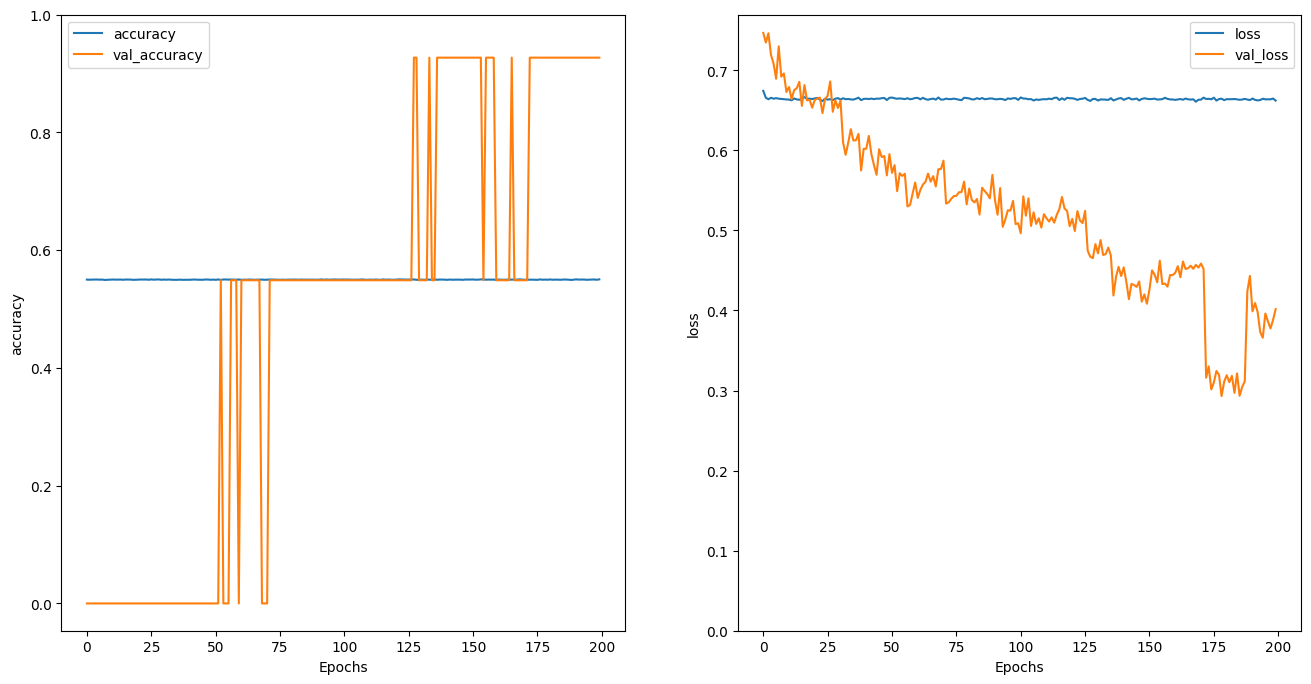

In [45]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [46]:
# predict on a sample text without padding
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 148ms/step
[1.4247617]


##### Experiment 4:

In [47]:
model = create_model(encoder_bigrams)
# predict on a sample formula using untrained model
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 81ms/step
[-0.02572106]


In [48]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [49]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])

run.finish()

Epoch 1/200
151/156 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6701 - accuracy: 0.5497 - val_loss: 0.7434 - val_accuracy: 0.0000e+00
Epoch 2/200
156/156 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


156/156 [==============================] - 2s 12ms/step - loss: 0.6615 - accuracy: 0.5500 - val_loss: 0.7147 - val_accuracy: 0.0000e+00
Epoch 3/200
146/156 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.5491INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6606 - accuracy: 0.5497 - val_loss: 0.7094 - val_accuracy: 0.0000e+00
Epoch 4/200
146/156 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.5490INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6594 - accuracy: 0.5502 - val_loss: 0.7021 - val_accuracy: 0.0000e+00
Epoch 5/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6586 - accuracy: 0.5499 - val_loss: 0.7327 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6603 - accuracy: 0.5495 - val_loss: 0.7053 - val_accuracy: 0.0000e+00
Epoch 7/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6605 - accuracy: 0.5500 - val_loss: 0.7094 - val_accuracy: 0.0000e+00
Epoch 8/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6602 - accuracy: 0.5498 - val_loss: 0.7153 - val_accuracy: 0.0000e+00
Epoch 9/200
154/156 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.5512INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


156/156 [==============================] - 2s 9ms/step - loss: 0.6602 - accuracy: 0.5500 - val_loss: 0.7017 - val_accuracy: 0.0000e+00
Epoch 10/200
145/156 [==========================>...] - ETA: 0s - loss: 0.6600 - accuracy: 0.5496INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


156/156 [==============================] - 2s 13ms/step - loss: 0.6598 - accuracy: 0.5496 - val_loss: 0.6848 - val_accuracy: 0.0000e+00
Epoch 11/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6606 - accuracy: 0.5502 - val_loss: 0.7296 - val_accuracy: 0.0000e+00
Epoch 12/200
146/156 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.5530INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6603 - accuracy: 0.5499 - val_loss: 0.6821 - val_accuracy: 0.0000e+00
Epoch 13/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6616 - accuracy: 0.5500 - val_loss: 0.6944 - val_accuracy: 0.0000e+00
Epoch 14/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6589 - accuracy: 0.5501 - val_loss: 0.7169 - val_accuracy: 0.0000e+00
Epoch 15/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6590 - accuracy: 0.5501 - val_loss: 0.7029 - val_accuracy: 0.0000e+00
Epoch 16/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6611 - accuracy: 0.5499 - val_loss: 0.6909 - val_accuracy: 0.0000e+00
Epoch 17/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6589 - accuracy: 0.5501 - val_loss: 0.7117 - val_accuracy: 0.0000e+00
Epoch 18/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6596 - accuracy: 0.5498 - val_loss: 0.7118 - v

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_113455-zqc7ldqj/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6597 - accuracy: 0.5502 - val_loss: 0.6592 - val_accuracy: 0.0000e+00
Epoch 50/200
156/156 [==============================] - 1s 5ms/step - loss: 0.6604 - accuracy: 0.5499 - val_loss: 0.6853 - val_accuracy: 0.0000e+00
Epoch 51/200
156/156 [==============================] - 1s 5ms/step - loss: 0.6597 - accuracy: 0.5503 - val_loss: 0.7058 - val_accuracy: 0.0000e+00
Epoch 52/200
156/156 [==============================] - 1s 5ms/step - loss: 0.6610 - accuracy: 0.5502 - val_loss: 0.7134 - val_accuracy: 0.0000e+00
Epoch 53/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6583 - accuracy: 0.5504 - val_loss: 0.6986 - val_accuracy: 0.0000e+00
Epoch 54/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6602 - accuracy: 0.5501 - val_loss: 0.7240 - val_accuracy: 0.0000e+00
Epoch 55/200
156/156 [==============================] - 1s 4ms/step - loss: 0.6599 - accuracy: 0.5500 - val_loss: 0.7058 - v

In [50]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 1ms/step - loss: 0.7236 - accuracy: 0.0000e+00
Test Loss: 0.723638117313385
Test Accuracy: 0.0


(0.0, 0.7525729775428772)

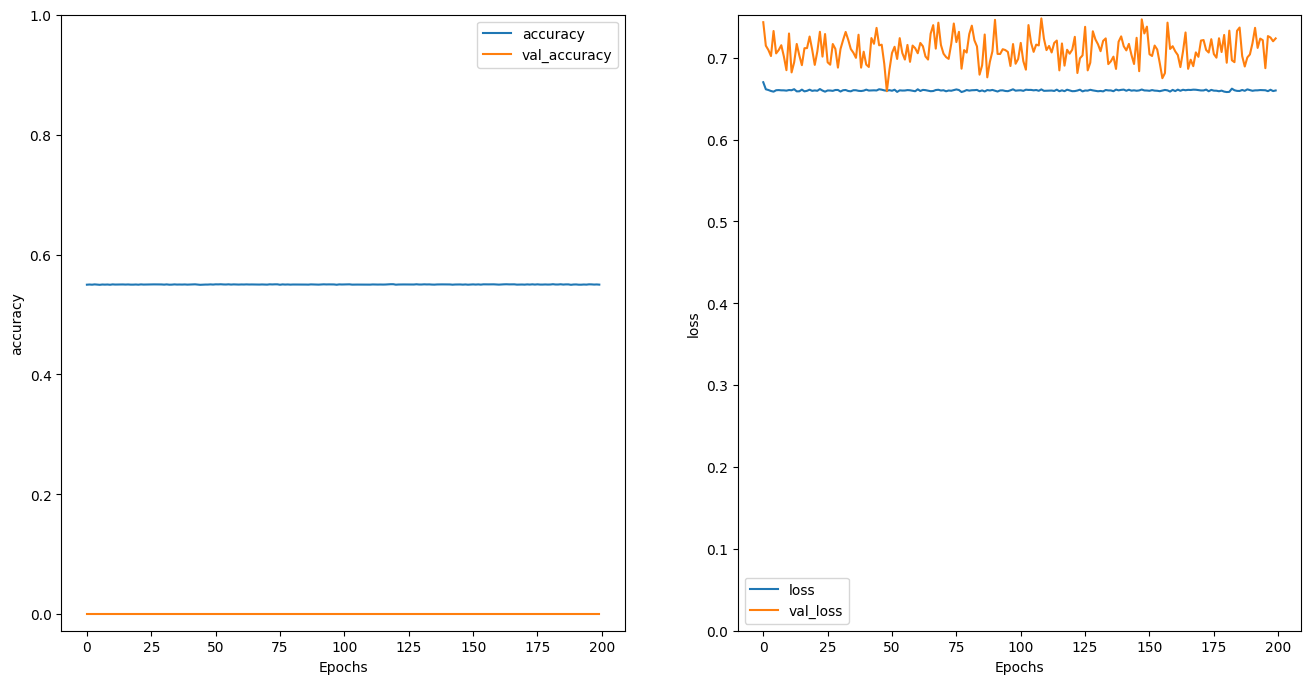

In [51]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [52]:
# predict on a sample text without padding
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 86ms/step
[0.06341894]


##### Experiment 5:

In [62]:
model = create_model(encoder_tf_idf, 30)
# predict on a sample formula using untrained model
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 107ms/step
[-0.00152158]


In [63]:
#model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [64]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "2-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)


history = model.fit(train_dataset, epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=VAL_STEPS_PER_EPOCH, steps_per_epoch=STEPS_PER_EPOCH,callbacks= [WandbCallback()])#[tensorboard_callback])

run.finish()

Epoch 1/200
132/156 [========================>.....] - ETA: 0s - loss: 0.6804 - accuracy: 0.5514INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 3s 13ms/step - loss: 0.6781 - accuracy: 0.5500 - val_loss: 0.7377 - val_accuracy: 0.0000e+00
Epoch 2/200
136/156 [=========================>....] - ETA: 0s - loss: 0.6510 - accuracy: 0.5551INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6495 - accuracy: 0.5578 - val_loss: 0.7156 - val_accuracy: 0.0000e+00
Epoch 3/200
136/156 [=========================>....] - ETA: 0s - loss: 0.6298 - accuracy: 0.6036INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6283 - accuracy: 0.6077 - val_loss: 0.6848 - val_accuracy: 0.2917
Epoch 4/200
143/156 [==========================>...] - ETA: 0s - loss: 0.6142 - accuracy: 0.6360INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6133 - accuracy: 0.6357 - val_loss: 0.6797 - val_accuracy: 0.2917
Epoch 5/200
144/156 [==========================>...] - ETA: 0s - loss: 0.6123 - accuracy: 0.6456INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6120 - accuracy: 0.6468 - val_loss: 0.6734 - val_accuracy: 0.3010
Epoch 6/200
150/156 [===========================>..] - ETA: 0s - loss: 0.6117 - accuracy: 0.6469INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 2s 12ms/step - loss: 0.6110 - accuracy: 0.6478 - val_loss: 0.6706 - val_accuracy: 0.3010
Epoch 7/200
144/156 [==========================>...] - ETA: 0s - loss: 0.6152 - accuracy: 0.6429INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6130 - accuracy: 0.6471 - val_loss: 0.6656 - val_accuracy: 0.2917
Epoch 8/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6107 - accuracy: 0.6466 - val_loss: 0.6726 - val_accuracy: 0.2917
Epoch 9/200
142/156 [==========================>...] - ETA: 0s - loss: 0.6071 - accuracy: 0.6492INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6093 - accuracy: 0.6483 - val_loss: 0.6638 - val_accuracy: 0.2917
Epoch 10/200
140/156 [=========================>....] - ETA: 0s - loss: 0.6055 - accuracy: 0.6525INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 8ms/step - loss: 0.6074 - accuracy: 0.6525 - val_loss: 0.6609 - val_accuracy: 0.2865
Epoch 11/200
143/156 [==========================>...] - ETA: 0s - loss: 0.6104 - accuracy: 0.6452INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6094 - accuracy: 0.6452 - val_loss: 0.6594 - val_accuracy: 0.2865
Epoch 12/200
148/156 [===========================>..] - ETA: 0s - loss: 0.6088 - accuracy: 0.6550INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6091 - accuracy: 0.6540 - val_loss: 0.6567 - val_accuracy: 0.2865
Epoch 13/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.6507 - val_loss: 0.6604 - val_accuracy: 0.2865
Epoch 14/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6090 - accuracy: 0.6527 - val_loss: 0.6598 - val_accuracy: 0.2865
Epoch 15/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6061 - accuracy: 0.6547 - val_loss: 0.6613 - val_accuracy: 0.2865
Epoch 16/200
152/156 [============================>.] - ETA: 0s - loss: 0.6097 - accuracy: 0.6507INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 2s 10ms/step - loss: 0.6093 - accuracy: 0.6509 - val_loss: 0.6530 - val_accuracy: 0.2865
Epoch 17/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6085 - accuracy: 0.6566 - val_loss: 0.6533 - val_accuracy: 0.2865
Epoch 18/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6100 - accuracy: 0.6513 - val_loss: 0.6616 - val_accuracy: 0.2854
Epoch 19/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6073 - accuracy: 0.6548 - val_loss: 0.6622 - val_accuracy: 0.2854
Epoch 20/200
133/156 [========================>.....] - ETA: 0s - loss: 0.6054 - accuracy: 0.6595INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6083 - accuracy: 0.6548 - val_loss: 0.6525 - val_accuracy: 0.2896
Epoch 21/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6113 - accuracy: 0.6524 - val_loss: 0.6533 - val_accuracy: 0.2896
Epoch 22/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6064 - accuracy: 0.6557 - val_loss: 0.6570 - val_accuracy: 0.2896
Epoch 23/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6099 - accuracy: 0.6519 - val_loss: 0.6624 - val_accuracy: 0.2896
Epoch 24/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6072 - accuracy: 0.6550 - val_loss: 0.6623 - val_accuracy: 0.2896
Epoch 25/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6074 - accuracy: 0.6545 - val_loss: 0.6592 - val_accuracy: 0.2896
Epoch 26/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6069 - accuracy: 0.6495 - val_loss: 0.6615 - val_accuracy: 0.2896
Epoch

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 2s 11ms/step - loss: 0.6058 - accuracy: 0.6523 - val_loss: 0.6521 - val_accuracy: 0.2958
Epoch 47/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6538 - val_loss: 0.6582 - val_accuracy: 0.2896
Epoch 48/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6052 - accuracy: 0.6534 - val_loss: 0.6638 - val_accuracy: 0.2896
Epoch 49/200
156/156 [==============================] - 0s 3ms/step - loss: 0.6017 - accuracy: 0.6552 - val_loss: 0.6670 - val_accuracy: 0.2896
Epoch 50/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6054 - accuracy: 0.6534 - val_loss: 0.6623 - val_accuracy: 0.2896
Epoch 51/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.6492 - val_loss: 0.6695 - val_accuracy: 0.2896
Epoch 52/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6060 - accuracy: 0.6526 - val_loss: 0.6761 - val_accuracy: 0.2896
Epoc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 1s 9ms/step - loss: 0.6025 - accuracy: 0.6547 - val_loss: 0.6502 - val_accuracy: 0.2990
Epoch 115/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6011 - accuracy: 0.6565 - val_loss: 0.6609 - val_accuracy: 0.2896
Epoch 116/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6045 - accuracy: 0.6538 - val_loss: 0.6608 - val_accuracy: 0.2958
Epoch 117/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6055 - accuracy: 0.6532 - val_loss: 0.6533 - val_accuracy: 0.2990
Epoch 118/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6064 - accuracy: 0.6512 - val_loss: 0.6558 - val_accuracy: 0.2896
Epoch 119/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6060 - accuracy: 0.6538 - val_loss: 0.6570 - val_accuracy: 0.2896
Epoch 120/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6038 - accuracy: 0.6520 - val_loss: 0.6693 - val_accuracy: 0.2896

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_114112-2rwgqg7q/files/model-best/assets


156/156 [==============================] - 2s 9ms/step - loss: 0.6050 - accuracy: 0.6550 - val_loss: 0.6493 - val_accuracy: 0.2990
Epoch 194/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.6561 - val_loss: 0.6621 - val_accuracy: 0.2896
Epoch 195/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6038 - accuracy: 0.6555 - val_loss: 0.6568 - val_accuracy: 0.2896
Epoch 196/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6035 - accuracy: 0.6556 - val_loss: 0.6653 - val_accuracy: 0.2885
Epoch 197/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6039 - accuracy: 0.6552 - val_loss: 0.6570 - val_accuracy: 0.2990
Epoch 198/200
156/156 [==============================] - 0s 2ms/step - loss: 0.6020 - accuracy: 0.6547 - val_loss: 0.6578 - val_accuracy: 0.2990
Epoch 199/200
156/156 [==============================] - 1s 3ms/step - loss: 0.6061 - accuracy: 0.6523 - val_loss: 0.6495 - val_accuracy: 0.2990

In [65]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 2ms/step - loss: 0.6555 - accuracy: 0.2990
Test Loss: 0.6555359959602356
Test Accuracy: 0.29895833134651184


(0.0, 0.7445351868867874)

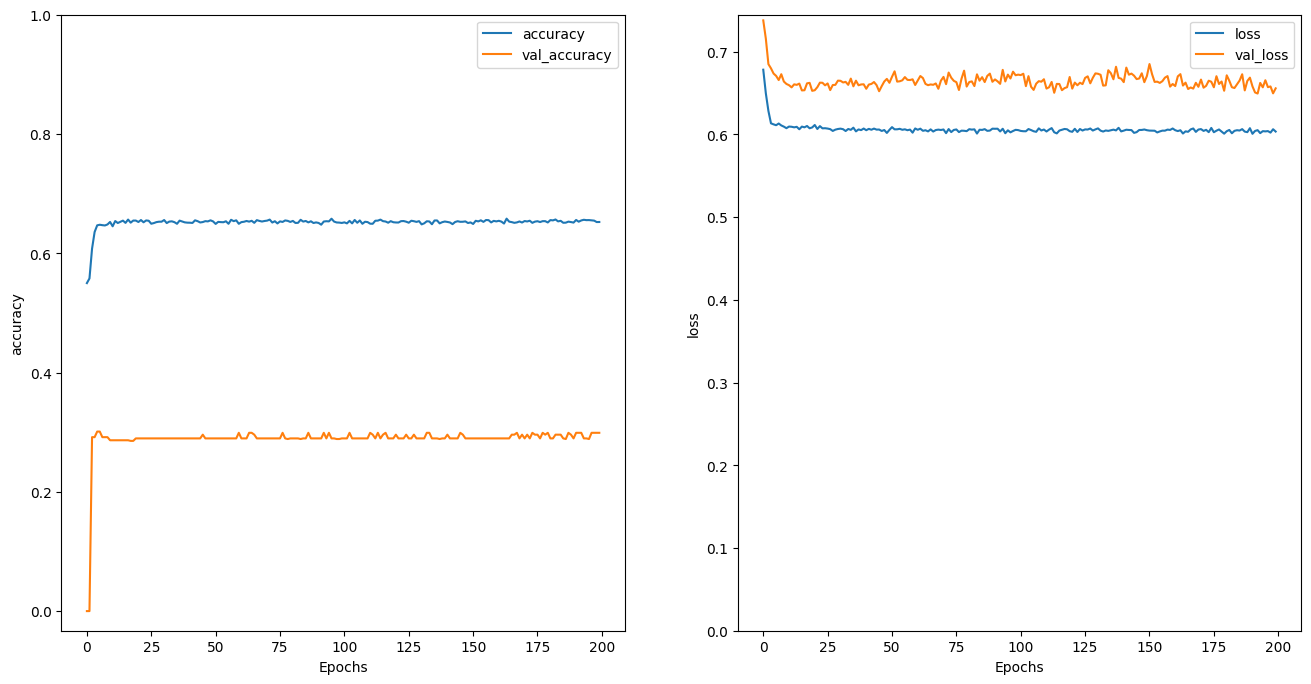

In [66]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [67]:
# predict on a sample text without padding
sample_text = "set_constant SET_BASIC"
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 74ms/step
[-1.1291047]
